# CNN to Detect Gravitational Lenses

---

## 1. Initial Imports

In [1]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab as py
import bisect
import cv2
import h5py
import scipy.misc
import warnings
import os
import pydot
import pydot_ng
import time
import timeit
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras import backend as K
from keras.utils import plot_model, to_categorical
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

from astropy.io import fits

from IPython.display import Image, display

warnings.filterwarnings("ignore")

Using TensorFlow backend.


## 2. Example of imadjust and denoising

In [2]:
nmbimg = '119819'

vout = (0,255)
def imadjust(src, tol=0.5, vin=[0,255], vout=vout):
    # src : input one-layer image (numpy array)
    # tol : tolerance, from 0 to 100.
    # vin  : src image bounds
    # vout : dst image bounds
    # return : output img

    dst = src.copy()
    tol = max(0, min(100, tol))

    if tol > 0:
        # Compute in and out limits
        # Histogram
        hist = np.zeros(256, dtype=np.int)
        for r in range(src.shape[0]):
            for c in range(src.shape[1]):
                hist[src[r,c]] += 1
        # Cumulative histogram
        cum = hist.copy()
        for i in range(1, len(hist)):
            cum[i] = cum[i - 1] + hist[i]

        # Compute bounds
        total = src.shape[0] * src.shape[1]
        low_bound = total * tol / 100
        upp_bound = total * (100 - tol) / 100
        vin[0] = bisect.bisect_left(cum, low_bound)
        vin[1] = bisect.bisect_left(cum, upp_bound)

    # Stretching
    if (vin[1] - vin[0]) > 0:
        scale = (vout[1] - vout[0]) / (vin[1] - vin[0])
    else:
        scale = 0
        
    for r in range(dst.shape[0]):
        for c in range(dst.shape[1]):
            vs = max(src[r,c] - vin[0], 0)
            vd = min(int(vs * scale + 0.5) + vout[0], vout[1])
            dst[r,c] = vd
    return dst

Filename: lensdata/DataVisualization/imageSDSS_G-119819.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (101, 101)   float32   
(101, 101)
Filename: lensdata/DataVisualization/imageSDSS_R-119819.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (101, 101)   float32   
(101, 101)
Filename: lensdata/DataVisualization/imageSDSS_I-119819.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (101, 101)   float32   
(101, 101)


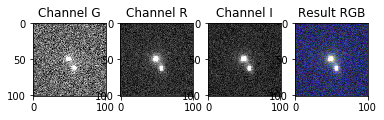

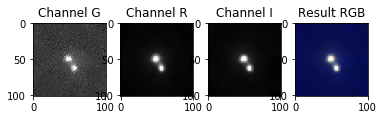

In [3]:
idximg = 'lensdata/DataVisualization/imageSDSS_'

image_fileG = idximg + 'G' + '-' + nmbimg + '.fits'
fits.info(image_fileG)
image_dataG  = fits.getdata(image_fileG, ext=0)
image_dataG  = np.float32(image_dataG)
image_dataG  = cv2.normalize(image_dataG, None, 0, 255, cv2.NORM_MINMAX)
image_dataG  = np.uint8(image_dataG)
image_dataGi = imadjust(image_dataG)
image_dataG  = cv2.fastNlMeansDenoising(image_dataGi, None, 30, 7, 21)
print(image_dataG.shape)

image_fileR =  idximg + 'R' + '-' + nmbimg + '.fits'
fits.info(image_fileR)
image_dataR = fits.getdata(image_fileR, ext=0)
image_dataR= np.float32(image_dataR)
image_dataR = cv2.normalize(image_dataR, None, 0, 255, cv2.NORM_MINMAX)
image_dataR = np.uint8(image_dataR)
image_dataRi = imadjust(image_dataR)
image_dataR = cv2.fastNlMeansDenoising(image_dataRi, None, 30, 7, 21)
print(image_dataR.shape)

image_fileI = idximg + 'I' + '-' + nmbimg + '.fits'
fits.info(image_fileI)
image_dataI = fits.getdata(image_fileI, ext=0)
image_dataI= np.float32(image_dataI)
image_dataI = cv2.normalize(image_dataI, None, 0, 255, cv2.NORM_MINMAX)
image_dataI = np.uint8(image_dataI)
image_dataIi = imadjust(image_dataI)
image_dataI = cv2.fastNlMeansDenoising(image_dataIi, None, 30, 7, 21)
print(image_dataI.shape)

# for image rgb only imadjust
img = np.zeros([image_dataG.shape[1], image_dataG.shape[1], 3])
img.shape
img[:,:,0] = image_dataIi
img[:,:,1] = image_dataRi
img[:,:,2] = image_dataGi
rgb = scipy.misc.toimage(img)
rgbi = np.array(rgb)

# for image rgb with imadjust and denoising
img = np.zeros([image_dataG.shape[1], image_dataG.shape[1], 3])
img.shape
img[:,:,0] = image_dataI
img[:,:,1] = image_dataR
img[:,:,2] = image_dataG
rgb = scipy.misc.toimage(img)
rgb = np.array(rgb)

plt.figure(1)
plt.subplot(141)
plt.imshow(image_dataGi, cmap='gray')
plt.title('Channel G')
plt.grid(False)
plt.subplot(142)
plt.imshow(image_dataRi, cmap='gray')
plt.title('Channel R')
plt.grid(False)
plt.subplot(143)
plt.imshow(image_dataIi, cmap='gray')
plt.title('Channel I')
plt.grid(False)
plt.subplot(144)
plt.imshow(rgbi)
plt.title('Result RGB')
plt.grid(False)
plt.savefig("imageSDSSImadjust.png")

plt.figure(2)
plt.subplot(141)
plt.imshow(image_dataG, cmap='gray')
plt.title('Channel G')
plt.grid(False)
plt.subplot(142)
plt.imshow(image_dataR, cmap='gray')
plt.title('Channel R')
plt.grid(False)
plt.subplot(143)
plt.imshow(image_dataI, cmap='gray')
plt.title('Channel I')
plt.grid(False)
plt.subplot(144)
plt.imshow(rgb)
plt.title('Result RGB')
plt.grid(False)
plt.savefig("imageSDSSImadandDenoise.png")

img = np.zeros([image_dataG.shape[1],image_dataG.shape[1],3])
img.shape
img[:,:,0] = image_dataI
img[:,:,1] = image_dataR
img[:,:,2] = image_dataG
rgb = scipy.misc.toimage(img)
rgb = np.array(rgb)

## 3. Loading Data

In [4]:
labels = pd.read_csv('lensdata/y_data20000fits.csv', delimiter=',', header=-1)
y_data = np.array(labels, np.uint8)

In [5]:
x_datasaved = h5py.File('lensdata/x_data20000fits.h5', 'r')
x_data = x_datasaved['data']
print(x_data.shape)

# change shape
x_data = np.moveaxis(x_data, -1, 0) 
x_data = np.moveaxis(x_data, -3, 0)
print(x_data.shape)

(20000, 101, 101, 4)
(20000, 4, 101, 101)


## 4. Preprocessing

In [6]:
# 10% to validation and 30% to testing
pVal  = x_data.shape[0]/10
ptest = pVal*3

In [7]:
x_val   = x_data[1:int(pVal)+1,:,:,:]
x_test  = x_data[int(pVal)+2:(int(pVal)+2)+int(ptest)+1,:,:,:]
x_train = x_data[int(ptest+pVal):x_data.shape[0],:,:,:]

print('Shape x ...')
print(x_val.shape)
print(x_test.shape)
print(x_train.shape)

Shape x ...
(2000, 4, 101, 101)
(6001, 4, 101, 101)
(12000, 4, 101, 101)


In [8]:
y_val   = y_data[1:int(pVal)+1,0]
y_test  = y_data[int(pVal)+2:(int(pVal)+2)+int(ptest)+1,0]
y_train = y_data[int(ptest+pVal):x_data.shape[0],0]
 
print('Shape y ...')
print(y_val.shape)
print(y_test.shape)
print(y_train.shape)

Shape y ...
(2000,)
(6001,)
(12000,)


In [9]:
# One Hot Encoding

y_train = to_categorical(y_train)
y_val   = to_categorical(y_val)
y_test  = to_categorical(y_test)

## 5. Modeling the CNN

In [10]:
model = Sequential()

model.add(Convolution2D(64, (3, 3), input_shape=(x_data.shape[1], 101, 101), data_format='channels_first'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3, 3), data_format='channels_first')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3, 3), data_format='channels_first')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3, 3), data_format='channels_first')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(512)) 
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(256)) 
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(64)) 
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(2))
model.add(Dense(2, activation='softmax')) 

In [11]:
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [12]:
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 99, 99)        2368      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 99, 99)        396       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 99, 99)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 49, 99)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 47, 97)       36992     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 47, 97)       388       
_________________________________________________________________
activation_2 (Activation)    (None, 128, 47, 97)       0         
__________

## 6. Data Augmentation

__In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better. Data Augmentation:__

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# datagen.fit(x_train)

## 7. Training the Network

See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
The first is the allow_growth option, which attempts to allocate only as much
GPU memory based on runtime allocations: it starts out allocating very little 
memory, and as Sessions get run and more GPU memory is needed, we extend the GPU memory region needed by 
the TensorFlow process. Note that we do not release memory, since that can lead 
to even worse memory fragmentation. To turn this option on, set the option in the ConfigProto by:

In [ ]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)

A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. Building Callbacks:

In [14]:
def get_callbacks(name_weights, patience_lr, name_csv):
    mcp_save = ModelCheckpoint(name_weights)
    csv_logger = CSVLogger(name_csv)
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, epsilon=1e-4, mode='max')
    return [mcp_save, csv_logger, reduce_lr_loss]

In [ ]:
name_weights = "Train_model_weights_{epoch:02d}.h5"
csv_name = "trainning_k.csv"

batch_size = 32
epochs = 35

callbacks = get_callbacks(name_weights=name_weights, patience_lr=10, name_csv=csv_name)
generator = datagen.flow(x_train, y_train, batch_size=batch_size)

In [ ]:
start = time.perf_counter()
history = model.fit_generator(
                  generator,
                  steps_per_epoch=len(x_train)//batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_val, y_val),
                  validation_steps=len(x_val),
                  callbacks=callbacks)

# sess.close()
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

In [ ]:
###### Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()
plt.savefig("AccxEpoch.png")

###### Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()
plt.savefig("LossxEpoch.png")

In [ ]:
#print(model.evaluate(x_test, y_test)) 
      
probs = model.predict_proba(x_test)
######## keep probabilities for the positive outcome only
probsp = probs[:, 1]
######## calculate AUC
auc = roc_auc_score(y_test[:,1], probsp)
print('AUC: %.3f' % auc)

      
######## calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test[:,1], probsp)


plt.figure()
plt.plot([0, 1], [0, 1], 'k--') # k = color black
plt.plot(fpr, tpr, label="AUC: %.3f" % auc, color='C1', linewidth=3) # for color 'C'+str(j), for j[0 9]
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.title('ROC')
plt.xlabel('false positive rate', fontsize=14)
plt.ylabel('true positive rate', fontsize=14)
    
plt.show()
plt.savefig("ROCLensDetectNet.png")

In [ ]:
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# Predict single images
n_images = 8
# Get images from test set
test_images = x_test[:n_images]
# Predicts
# Use the model to predict the images class
preds = list(model.predict_proba(test_images))
# print("Large CNN Error: %.2f%%" % (100-scores[1]*100))
# Display
vout = (0,255)
for i in range(n_images):
    output=np.where(preds[i]==preds[i].max())
    print("Model prediction:", output[0][0])
    #print(y_test[:,1])
    print("Real:", np.uint8(y_test[i,1]))